In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


{'Long Task': [(0, 10), (13, 15), (17, 27), (31, 34), (37, 46), (50, 53), (56, 66), (72, 74), (76, 86), (91, 93), (96, 106)], 'Short Task': [(10, 11), (11, 12), (12, 13), (15, 16), (16, 17), (27, 28), (28, 29), (29, 30), (30, 31), (34, 35), (35, 37), (46, 47), (47, 48), (48, 49), (49, 50), (53, 54), (55, 56), (66, 67), (67, 68), (68, 69), (69, 70), (71, 72), (74, 75), (75, 76), (86, 87), (87, 88), (88, 89), (89, 91), (93, 94), (94, 95), (95, 96), (106, 107), (107, 108), (108, 109), (109, 111)]}
{'TIM3': [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48, 51, 54, 57, 60, 63, 66, 69, 72, 75, 78, 81, 84, 87, 90, 93, 96, 99, 102, 105, 108, 111], 'TIM2': [10, 27, 46, 66, 86, 106]}


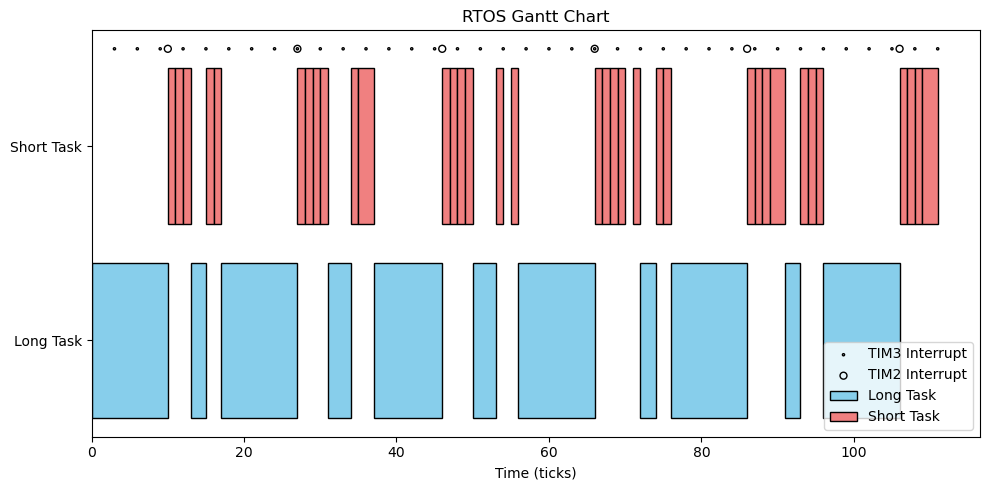

In [29]:
import re
import matplotlib.pyplot as plt

# --- Step 1: Parse the log for events ---
events = []

# Get data from sample_data.txt
with open('sample_data.txt', 'r') as f:
    for line in f:
        line = line.strip()
        # Match start events
        # search b/c interrupt might run in the middle of another print
        tim2_interrupt = re.search(r'Tim2 running\. Time: (\d+)', line)
        tim3_interrupt = re.search(r'Tim3 running\. Time: (\d+)', line)
        # match b/c can start looking from beginning of line
        start_long = re.match(r'Long task started\. Time: (\d+)', line)
        pause_long = re.match(r'Long task paused\. Time: (\d+)', line)
        resume_long = re.match(r'Long task resumed\. Time: (\d+)', line)
        finish_long = re.match(r'Long task finished\. Time: (\d+)', line)
        start_short = re.match(r'Short task started\. Time: (\d+)', line)
        pause_short = re.match(r'Short task paused\. Time: (\d+)', line)
        resume_short = re.match(r'Short task resumed\. Time: (\d+)', line)
        finish_short = re.match(r'Short task finished\. Time: (\d+)', line)

        if tim2_interrupt:
            events.append({'task': 'TIM2', 'action': 'temp_interrupt', 'time': int(tim2_interrupt.group(1))})
        elif tim3_interrupt:
            events.append({'task': 'TIM3', 'action': 'temp_interrupt', 'time': int(tim3_interrupt.group(1))})
        elif start_long:
            events.append({'task': 'Long Task', 'action': 'start', 'time': int(start_long.group(1))})
        elif pause_long:
            events.append({'task': 'Long Task', 'action': 'end', 'time': int(pause_long.group(1))})
        elif resume_long:
            events.append({'task': 'Long Task', 'action': 'start', 'time': int(resume_long.group(1))})
        elif finish_long:
            events.append({'task': 'Long Task', 'action': 'end', 'time': int(finish_long.group(1))})
        elif start_short:
            events.append({'task': 'Short Task', 'action': 'start', 'time': int(start_short.group(1))})
        elif pause_long:
            events.append({'task': 'Short Task', 'action': 'end', 'time': int(pause_short.group(1))})
        elif resume_short:
            events.append({'task': 'Short Task', 'action': 'start', 'time': int(resume_short.group(1))})
        elif finish_short:
            events.append({'task': 'Short Task', 'action': 'end', 'time': int(finish_short.group(1))})

# --- Step 2: Group into task durations ---
# We will track currently running tasks
task_times = {'Long Task': [], 'Short Task': []}
running_tasks = {}
single_events = {'TIM3': [], 'TIM2': []}

for event in events:
    task = event['task']
    action = event['action']
    time = event['time']

    if action == 'start':
        running_tasks[task] = time
    elif action == 'end':
        if task in running_tasks:
            start_time = running_tasks.pop(task)
            task_times[task].append((start_time, time))
    elif action == 'temp_interrupt':
        single_events[task].append(time)

print(task_times)
print(single_events)

# --- Step 3: Plot using matplotlib ---
fig, ax = plt.subplots(figsize=(10, 5))

colors = {'Long Task': 'skyblue', 'Short Task': 'lightcoral'}

y_pos = {'Long Task': 0, 'Short Task': 1}

# Plot tasks
for task, periods in task_times.items():
    for start, end in periods:
        ax.barh(y_pos[task], end - start, left=start, color=colors[task], edgecolor='black', label=task)

# Plot single events
for event_name, times in single_events.items():
    if event_name == 'TIM2':
        dot_size = 100
        label = 'TIM2 Interrupt'
    elif event_name == 'TIM3':
        dot_size = 10
        label = 'TIM3 Interrupt'
    ax.scatter(times, [1.5] * len(times), label=label, marker='.', edgecolor='black', facecolor='none', s=dot_size)

# Make sure legend doesn't repeat
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys())

ax.set_yticks([y_pos['Long Task'], y_pos['Short Task']])
ax.set_yticklabels(['Long Task', 'Short Task'])
ax.set_xlabel('Time (ticks)')
ax.set_title('RTOS Gantt Chart')

plt.tight_layout()
plt.show()
